In [1]:
import pysal as ps
import scipy.sparse as spar
import numpy as np
import sklearn.metrics.pairwise as skm
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = ps.pdio.read_files(ps.examples.get_path('NAT.shp'))
W = ps.weights.Rook.from_dataframe(df)

In [3]:
attributes = df.filter(like='90').columns.tolist() + df.filter(like='89').columns.tolist()

In [4]:
Xmat = df[attributes].values
Xmat = (Xmat - Xmat.mean(axis=0)) / Xmat.std(axis=0)

### Is it faster to (A) only compute the distance metric for adjacent pairs or (B) do the full kernel dissimilarity matrix & then filter by adjacency?

In [5]:
def do_dissim_by_index(X, W, metric=skm.manhattan_distances):
    if 'sparse' in W._cache:
        del W._cache['sparse']
    indices = W.sparse.nonzero()
    data = []
    N,P = X.shape

    for row,col in zip(*indices):
        data.append(metric(X[row].reshape(1,-1), X[col].reshape(1,-1)).item())
    return spar.csc_matrix((data, (indices[0], indices[1])), shape=(N,N))
def do_dissim_by_filter(X, W, metric=skm.manhattan_distances):
    if 'sparse' in W._cache:
        del W._cache['sparse']
    return W.sparse * metric(X)

In [6]:
%timeit do_dissim_by_index(Xmat, W)

1.21 s ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%timeit do_dissim_by_filter(Xmat, W)

252 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### It is between 2x and 5x faster to do the full kernel and then filter by adjacency when the data size is N~3000

# Small simple SKATER

A conceptual overview of the algorithm:

1. Build a spatial binary contiguity graph, $W$
2. For spatial neighbors, compute a dissimilarity (negative affinity) measure $C$
3. Compute the minimum spanning tree over the weighted undirected graph, $W \circ C$
4. Until $p=P$ partitions are found:
  - for each segment $e_{a,b}$ of the MST with link from node $a$ into node $b$:
    - compute the dissimilarity scores of the $p$ subtrees formed by removing the link into $b$, where the dissimilarity score is some measure of dispersion for the attributes of atoms $i$ in subgraph $j$, $j = 1, 2, \dots p$
    - reduce the $p$-vector of dissimilarity scores (either by sum, product, min, max, etc.) and store this as the score $s_{a,b}$ of edge $e_{a,b}$. 
    - if $s_{a,b}$ is the first considered, let it be the running optimal score, $\tilde s_{a,b}$. 
    - if $s_{a,b} < \tilde s_{a,b}$ set $s_{a,b} \def \tilde s_{a,b}$, else discard $s_{a,b}$.
  - remove $v_{a,b}$ with score $\tilde s_{a,b}$ from the MST.

In [8]:
import geopandas as gpd

In [9]:
tx = gpd.read_file(ps.examples.get_path('NAT.shp')).query('STATE_NAME == "Texas"')

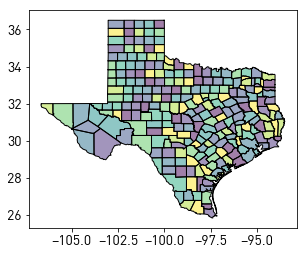

In [10]:
tx.plot()

### Let's build a contiguity graph

In [11]:
Wtx = ps.weights.Rook.from_dataframe(tx)

### Focus on the attributes from the 89/90 boundary in NAT

In [12]:
attributes = tx.filter(like='90').columns.tolist() + tx.filter(like='89').columns.tolist()

In [13]:
Xtx = tx[attributes].values
Xtx = (Xtx - Xtx.mean(axis=0)) / Xtx.std(axis=0)

### Use a given dissimilarity metric from scikit

In [14]:
dissimilarity_tx = skm.manhattan_distances(Xtx)

### Build the graph, noting that 0 is null, not zero cost

In [15]:
txgraph = spar.csgraph.csgraph_from_dense(Wtx.sparse.toarray() * dissimilarity_tx, null_value=0)

Now, I will typically work with the nonzero indices, which give us the in-node and out-node of each link in the MST:

In [16]:
tx_indices = txgraph.nonzero()

I'll also construct the initial MST:

In [17]:
MST_tx = spar.csgraph.minimum_spanning_tree(txgraph)

In [18]:
tx_mst_indices = np.vstack(MST_tx.nonzero()).T

In [19]:
tx['centroids'] = tx.geometry.apply(lambda x: tuple(np.hstack(x.centroid.xy)))

In [20]:
tx_centroids = np.vstack(tx.centroids.values)

To visualize, the MST is below:

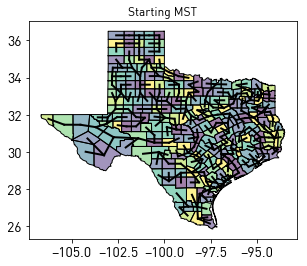

In [26]:
tx.plot()
ax = plt.gca()
[ax.plot(*np.vstack((tx_centroids[a], tx_centroids[b])).T, color='k', linewidth=2) for (a,b) in tx_mst_indices];
plt.title("Starting MST")
plt.show()

In [22]:
import copy
from tqdm import tqdm
from collections import namedtuple

### Set a quorum on the minimum feasible cluster size

I don't recall this being in the original SKATER implementation, but it'd be super easy to implement here as well as using `bounder` constructs to make it very general. 

In [23]:
quorum = 10

### Define `target` regions and initialize the search

In [24]:
deletion = namedtuple('deletion', ('in_node', 'out_node', 'score', 'quorum'))
target = 8
current_n_subtrees = 0
#while current_n_subtrees < target:
best_deletion = deletion(np.nan, np.nan, np.inf, np.inf)
current_n_subtrees, current_labels = spar.csgraph.connected_components(MST_tx, directed=False)

### Do the search

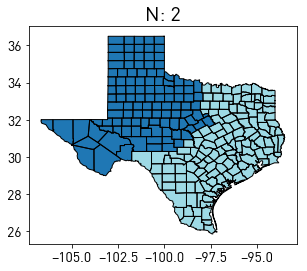

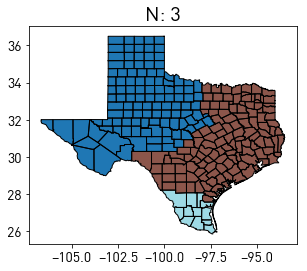

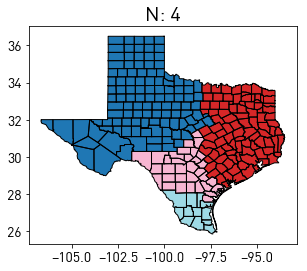

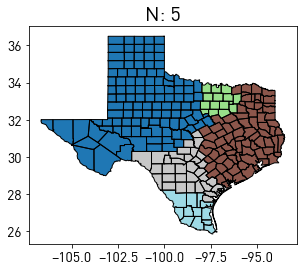

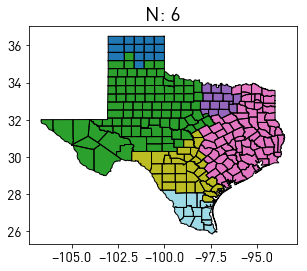

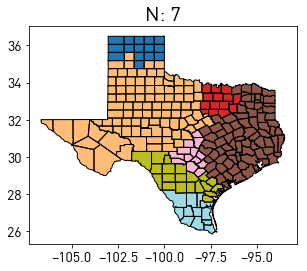

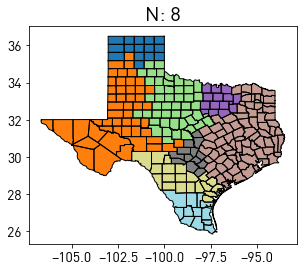

In [25]:
while current_n_subtrees < target: # while we don't have enough regions
    for in_node, out_node in np.vstack(MST_tx.nonzero()).T: #iterate through edges of the MST
        local_MST = copy.deepcopy(MST_tx)

        # delete the candidate link
        local_MST[in_node, out_node] = 0 
        local_MST = spar.csgraph.csgraph_from_dense(local_MST.toarray(), null_value=0)
        
        # get the subgraphs of the candidate deleted-MST
        n_subtrees, labels = spar.csgraph.connected_components(local_MST, directed=False) 
        
        # sanity check to ensure that removal generates more disconnected partitions
        if n_subtrees <= current_n_subtrees: 
            raise Exception('Malformed MST!')
            
        # score the subtrees according to a middle point in attribute space
        component_scores = [skm.manhattan_distances(Xtx[labels==l,:],
                                                    Y=Xtx[labels==l,:].mean(axis=0).reshape(1,-1)).sum()
                            for l in range(n_subtrees)]
        
        # ensure the subgraphs are big enough to live alone
        _,component_quorums = np.unique(labels, return_counts=True)
        score = np.sum(component_scores)

        # if they're big enough & improving, take the move
        if score < best_deletion.score and (component_quorums > quorum).all():
            best_deletion = deletion(in_node, out_node, score, component_quorums)

    # finalize the best move found into the source graph
    MST_tx[best_deletion.in_node, best_deletion.out_node] = 0
    MST_tx = spar.csgraph.csgraph_from_dense(MST_tx.toarray(), null_value=0)
    current_n_subtrees, current_labels = spar.csgraph.connected_components(MST_tx, directed=False)
    
    # store the current best to plot it for viewers
    tx['current_labels'] = current_labels
    tx.plot('current_labels', cmap='tab20', alpha=1)
    plt.title('N: {}'.format(current_n_subtrees), fontsize=20)
    plt.show()

### How different is this from a clustering using those same dissimilarity measures (cast to similarity measures) using spatially-encouraged spectral clustrering?

In [37]:
aff_tx = np.exp(-dissimilarity_tx) * Wtx.sparse

In [38]:
from sklearn import cluster as clust

In [46]:
tx['sk_labels'] = clust.SpectralClustering(n_clusters=8, affinity='precomputed').fit(aff_tx).labels_

/home/ljw/anaconda3/envs/ana/lib/python3.6/site-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


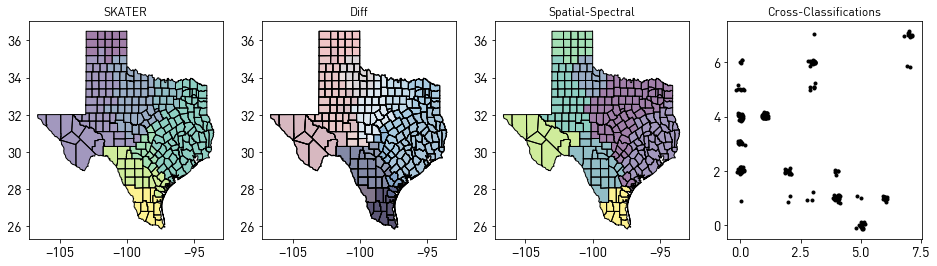

In [60]:
f,ax = plt.subplots(1,4,figsize=(16,4))
tx.plot('sk_labels', ax=ax[2])
tx.plot('sk_labels', ax=ax[1], cmap='Reds', alpha=.5)
tx.plot('current_labels', ax=ax[0])
tx.plot('current_labels', ax=ax[1], cmap='Blues', alpha=.5)
ax[3].scatter(tx.sk_labels + np.random.normal(0,.075, size=len(tx)),
              tx.current_labels + np.random.normal(0,.075, size=len(tx)), 
              color='k', marker='.')
ax[0].set_title("SKATER")
ax[2].set_title("Spatial-Spectral")
ax[1].set_title("Diff")
ax[3].set_title("Cross-Classifications")